In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import chainer
from dataset_4channel import RotatedSquaresDataset
import matplotlib.pyplot as plt
import numpy as np
import functions_rotation as fr 
from tests import *
from chainer import cuda 
import cupy
from chainer.optimizers import MomentumSGD,Adam 

db = RotatedSquaresDataset()

Excellent, now let's initialize the network.

In [3]:
from Network_4channel import VGGNet
net = VGGNet()
net.to_gpu(0)

# Optimizer
# optimizer =MomentumSGD(lr= 0.05)
optimizer = Adam(alpha= 0.0001)
optimizer.setup(net)

Let's begin the training process.

  0%|          | 0/500 [00:00<?, ?it/s]

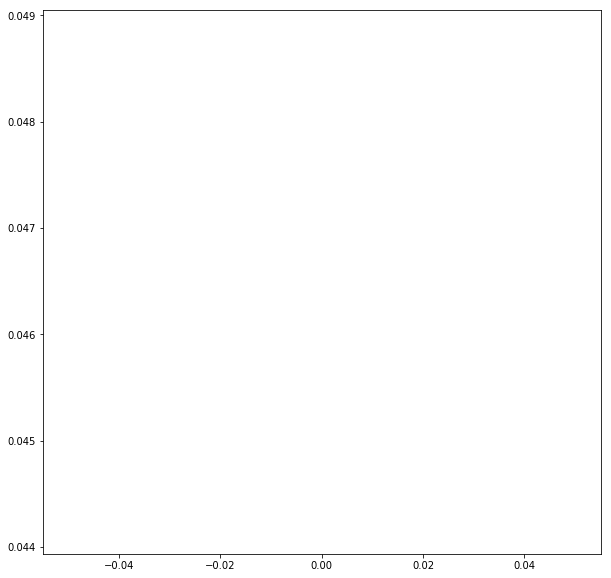

 10%|█         | 50/500 [00:15<02:11,  3.41it/s]

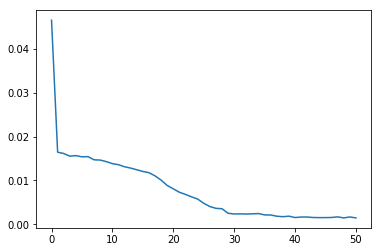

 20%|██        | 100/500 [00:30<01:56,  3.42it/s]

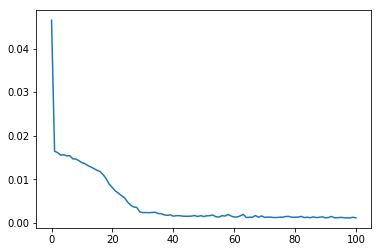

 30%|███       | 150/500 [00:44<01:42,  3.43it/s]

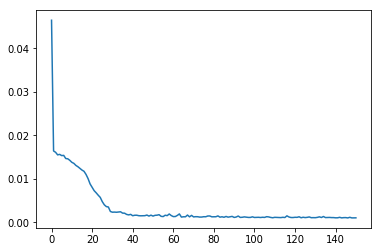

 40%|████      | 200/500 [00:59<01:27,  3.42it/s]

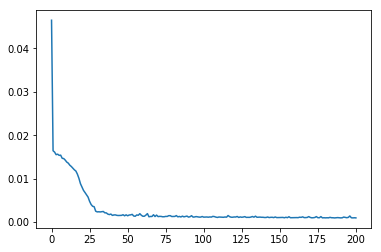

 50%|█████     | 250/500 [01:14<01:12,  3.43it/s]

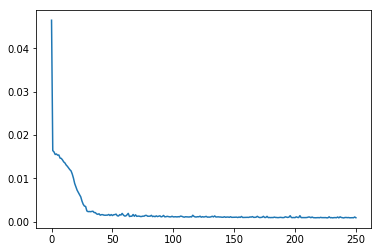

 60%|██████    | 300/500 [01:29<00:58,  3.42it/s]

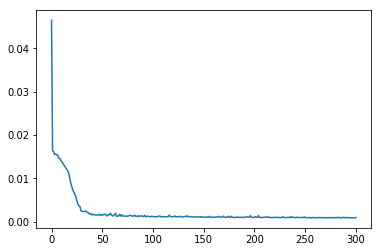

 70%|███████   | 350/500 [01:43<00:43,  3.42it/s]

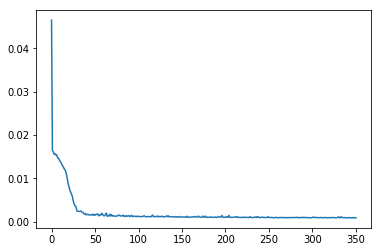

 80%|████████  | 400/500 [01:58<00:29,  3.42it/s]

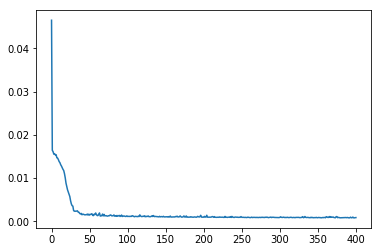

 90%|█████████ | 450/500 [02:13<00:14,  3.41it/s]

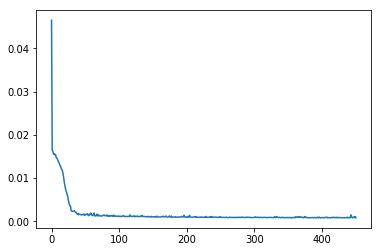

100%|██████████| 500/500 [02:27<00:00,  3.42it/s]


In [4]:
from tqdm import tqdm
losses = []

plt.figure(figsize=(10,10))
dimensions =[80.0,40.0]
norm_factor = 20.0 # We'll normalize the offsets by the largest side and then multiply the shift vector by this factor

# Training for loop
for i in tqdm(range(500)):
    imgs, labels = db.generate_batch(num_imgs=5, h=dimensions[0], w=dimensions[1], num_boxes=1, image_size=320)
    imgs_down, labels_down = fr.downsample(imgs, labels)
    
    net.to_gpu(0)

    imgs_gpu = chainer.Variable(cuda.to_gpu(imgs)) #gpu
    
    gt_class, gt_loc = fr.encode_y(imgs_down,norm_factor , labels_down) #cpu
    
    # Pass the ground truths to the gpu
    gt_class.to_gpu(0)
    gt_loc.to_gpu(0)

    pred_class, pred_loc = net(imgs_gpu) #net(imgs) #gpu
    
    
   # Loss calculation
#     class_loss = classification_loss(pred_class, gt_class)

#     class_loss = regression_loss(pred_loc, gt_loc, gt_class)
    
    
    # Calculate the net loss 
    net_loss = loss(pred_class, pred_loc, gt_class, gt_loc, lambd=1.0)
    #print(net_loss.debug_print())
    #net_loss.to_gpu(0)
    
    # Update network
    net.zerograds()
    net_loss.backward()
    optimizer.update()
    
    # Print loss
    losses.append(net_loss.data.get())
    
    #print(net_loss.data)
    if i % 50 == 0:
        gt_loc.to_cpu()
        pred_loc.to_cpu()
        plt.plot(range(len(losses)), losses)
        plt.show()
#         plt.figure()
#         plt.imshow(gt_loc[0,0,:,:].data,)
#         plt.colorbar()
#         plt.show()


#         plt.figure()
#         plt.imshow(pred_loc[0,0,:,:].data,)
#         plt.colorbar()
#         plt.show()
    
    
# Final loss plot


In [13]:
b = 1
norm_factor = 20
# Format is x1, y1, x2, y2

In [14]:
from skimage.draw import line
import matplotlib.pyplot as plt

In [15]:
pred_class.to_cpu()
pred_loc.to_cpu()
gt_class.to_cpu()
gt_loc.to_cpu()

In [129]:
def loc_to_vectors(pred_loc, pred_class, sparsity=1.0):
    """
    Converts a loc shift tensor into list of vectors to plot. Useful for visualizing density.
    
    Args:
        pred_loc (b,4,H,W): Loc shift tensor from base location (x,y)
        pred_class (b,1,H,W): Loc class probabilities of being a valid candidate hypothesis
        sparsity (scalar): Probability of selecting a particular vector
        
    Returns:
        vectors_batch (list(list(vector))): List of list of vectors to be drawn /img/batch
    """
    vectors_batch = [] # Vectors in all the images in the batch
    
    for b in range(pred_loc.shape[0]):
        vectors_img  = [] # Vectors in a single image
        
        for y in range(pred_loc.shape[2]):
            for x in range(pred_loc.shape[3]):
                shift_vec_left = pred_loc[b,0:2,y,x] # Assuming that the format is x1,y1
                shift_vec_right = pred_loc[b,2:4,y,x]
                base_vec = np.array([x,y])
                
                if np.abs(shift_vec_left).sum() and pred_class[b,0,y,x]>0.8: # Assuming the shift is non zero, this can be changed to a different condition
                    vectors_img.append([base_vec, base_vec + norm_factor*shift_vec_left, base_vec + norm_factor*shift_vec_right])
                
        vectors_batch.append(vectors_img)
        
    return vectors_batch

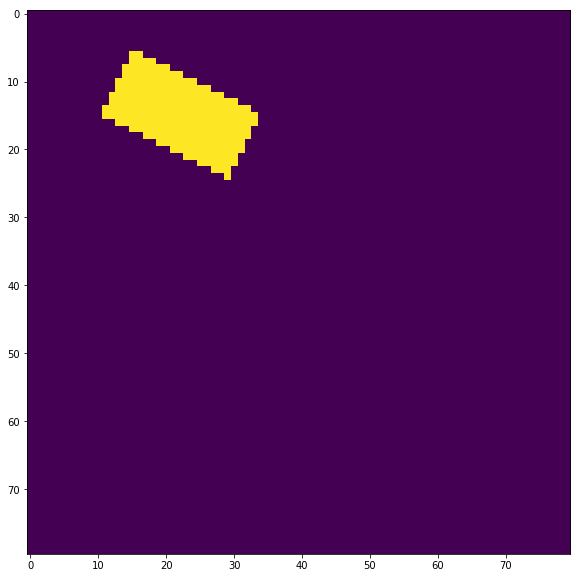

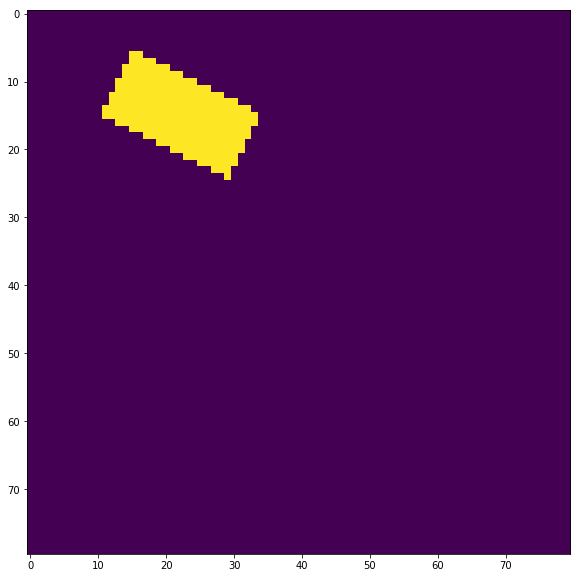

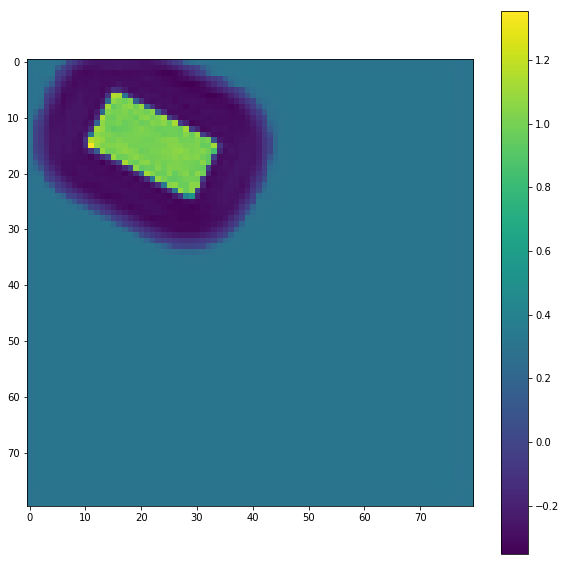

In [130]:

plt.imshow(pred_class[0,0,:,:].data)
plt.colorbar()
plt.show()

In [131]:
vectors_batch = loc_to_vectors(pred_loc.data, pred_class.data)

image
[array([24, 18]), array([ 11.16915131,  14.12448812]), array([ 32.70072842,  16.15074444])]
[array([20, 13]), array([ 12.26943493,  13.89763165]), array([ 32.77948856,  16.02168369])]
[array([20, 14]), array([ 12.9122138 ,  14.66396713]), array([ 32.54484177,  16.33963251])]
[array([23, 17]), array([ 11.73651695,  14.65690207]), array([ 32.63602829,  16.51835513])]
[array([12, 13]), array([ 12.825665 ,  13.7574749]), array([ 30.9003334 ,  13.01945496])]
[array([24, 10]), array([  9.81674385,  12.92141914]), array([ 31.57150888,  17.82825947])]
[array([23, 13]), array([ 10.88110542,  14.36881351]), array([ 32.41552162,  15.87014008])]
[array([30, 21]), array([ 14.10954952,  13.04304314]), array([ 32.9962039 ,  16.27055025])]
[array([31, 19]), array([ 13.88560104,  12.42950583]), array([ 31.86335421,  18.58989024])]
[array([20, 11]), array([ 11.15084076,  12.96310282]), array([ 31.76084042,  16.47088385])]
[array([17, 11]), array([ 12.16487122,  11.79869747]), array([ 33.32547188, 

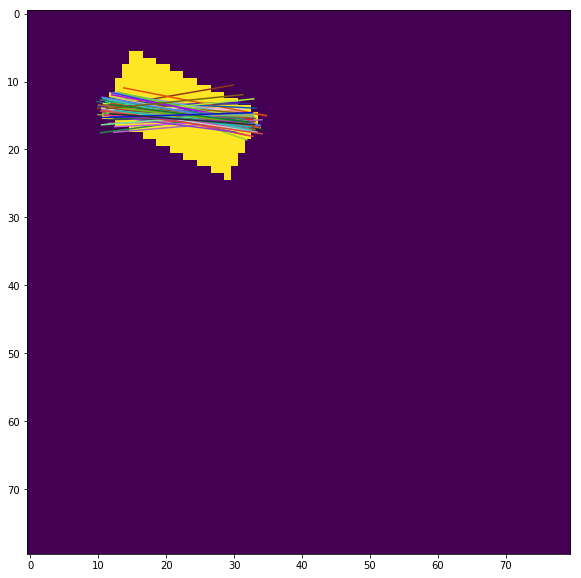

image
[array([24, 47]), array([ 20.12281919,  36.6863842 ]), array([ 39.93538284,  49.11030722])]
[array([27, 38]), array([ 22.1430583 ,  37.39294457]), array([ 42.84098053,  42.34199572])]
[array([41, 36]), array([ 23.25887299,  40.35778379]), array([ 40.04313207,  44.49868011])]
[array([34, 46]), array([ 19.6155014 ,  43.40534306]), array([ 43.05106735,  40.94135857])]
[array([40, 34]), array([ 23.59738541,  36.76968241]), array([ 39.47362542,  44.81774712])]
[array([36, 42]), array([ 21.20080757,  39.68300653]), array([ 41.62832832,  42.71815491])]
[array([39, 39]), array([ 21.80157852,  39.45626879]), array([ 41.6481843 ,  42.85281086])]
[array([43, 39]), array([ 23.97523117,  38.107126  ]), array([ 41.05837393,  41.40154028])]
[array([31, 36]), array([ 20.8461771 ,  40.37187672]), array([ 43.48440933,  39.88916492])]
[array([26, 48]), array([ 19.30725193,  37.97708321]), array([ 40.8075819 ,  45.17494965])]
[array([33, 42]), array([ 19.93958855,  41.27117944]), array([ 43.51624298

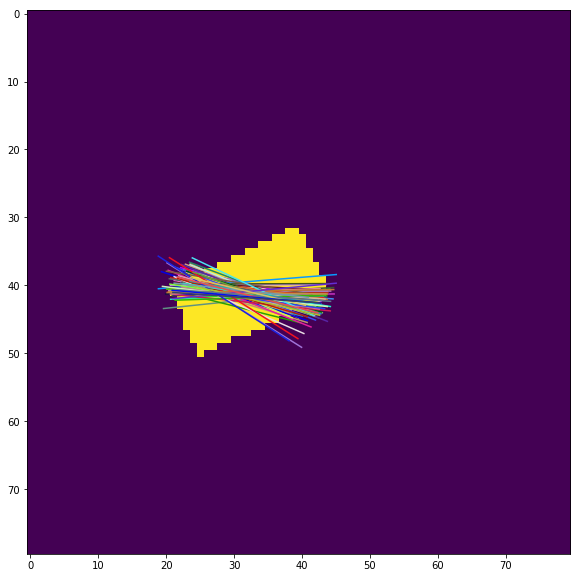

image
[array([21, 20]), array([ 17.40237331,  16.75726175]), array([ 37.23225212,  26.82533503])]
[array([30, 23]), array([ 16.03464127,  15.74644136]), array([ 35.20633936,  26.37311745])]
[array([25, 16]), array([ 18.39507961,  14.11172366]), array([ 36.42055988,  26.67920208])]
[array([29, 18]), array([ 15.9128685 ,  17.31922197]), array([ 35.68755054,  26.87181759])]
[array([23, 18]), array([ 18.76712132,  14.55071139]), array([ 36.73273087,  29.22428894])]
[array([30, 26]), array([ 16.99073982,  14.71539211]), array([ 36.80449486,  27.76641941])]
[array([28, 26]), array([ 16.81904411,  15.77463913]), array([ 36.2035017 ,  28.24553823])]
[array([24, 13]), array([ 16.99095154,  16.88271093]), array([ 34.96621704,  24.71462059])]
[array([33, 21]), array([ 15.61517715,  16.34533119]), array([ 33.63819885,  24.96556616])]
[array([20, 15]), array([ 17.21332192,  13.32704306]), array([ 37.3955574 ,  24.87280846])]
[array([28, 21]), array([ 16.27492237,  14.80696535]), array([ 36.41119289

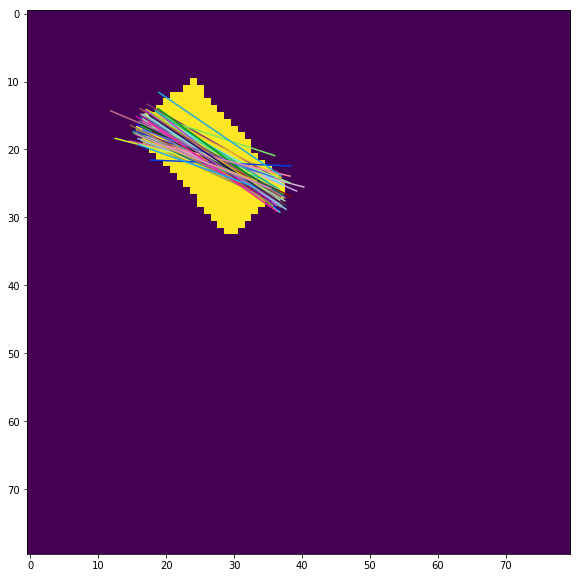

image
[array([20, 26]), array([ 16.69263959,  26.19442081]), array([ 38.63363457,  21.51299191])]
[array([29, 20]), array([ 18.35359192,  26.41731024]), array([ 38.99869347,  21.84923887])]
[array([39, 21]), array([ 19.94581795,  21.16854763]), array([ 36.21297145,  22.60872221])]
[array([23, 32]), array([ 14.67012787,  21.57930756]), array([ 36.61577511,  24.52844429])]
[array([34, 21]), array([ 17.25907898,  25.60212708]), array([ 39.42551279,  20.6342659 ])]
[array([37, 18]), array([ 18.43130493,  22.44228172]), array([ 35.4179163 ,  20.63347149])]
[array([23, 27]), array([ 18.07478952,  25.82525563]), array([ 38.94711494,  20.42501545])]
[array([24, 25]), array([ 18.11819363,  26.08663082]), array([ 39.49068928,  21.1111927 ])]
[array([27, 20]), array([ 19.28049994,  27.41552353]), array([ 39.73838997,  21.12546682])]
[array([21, 24]), array([ 18.56051183,  25.61137342]), array([ 39.10890579,  19.96458912])]
[array([32, 24]), array([ 17.02964211,  26.2769022 ]), array([ 37.47570467

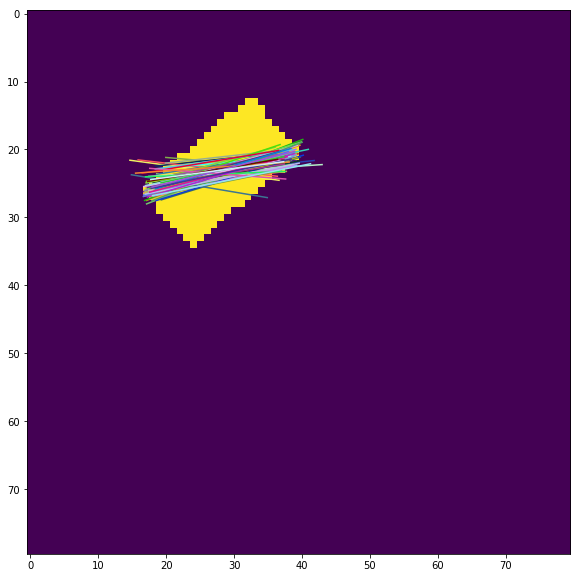

image
[array([45, 40]), array([ 27.13208008,  34.83217621]), array([ 46.00829363,  39.54140782])]
[array([39, 36]), array([ 28.64012146,  30.37898254]), array([ 47.11063957,  43.65235186])]
[array([30, 33]), array([ 28.62910867,  30.77198434]), array([ 48.76830101,  42.42541313])]
[array([34, 30]), array([ 29.31510448,  33.92947435]), array([ 47.76786232,  41.38118744])]
[array([39, 31]), array([ 26.13232231,  31.44247389]), array([ 46.18811274,  40.80368614])]
[array([31, 33]), array([ 28.5844121 ,  30.61078835]), array([ 48.85425377,  42.86264706])]
[array([47, 40]), array([ 28.19699478,  38.83194685]), array([ 44.39974141,  41.67798281])]
[array([39, 32]), array([ 25.75268364,  32.87098837]), array([ 46.69171   ,  42.67758751])]
[array([46, 44]), array([ 28.35533142,  35.89658737]), array([ 47.8988061 ,  42.90780926])]
[array([41, 39]), array([ 28.51939869,  32.18876648]), array([ 47.45314217,  41.78999567])]
[array([33, 29]), array([ 26.08415651,  32.04548979]), array([ 45.42879105

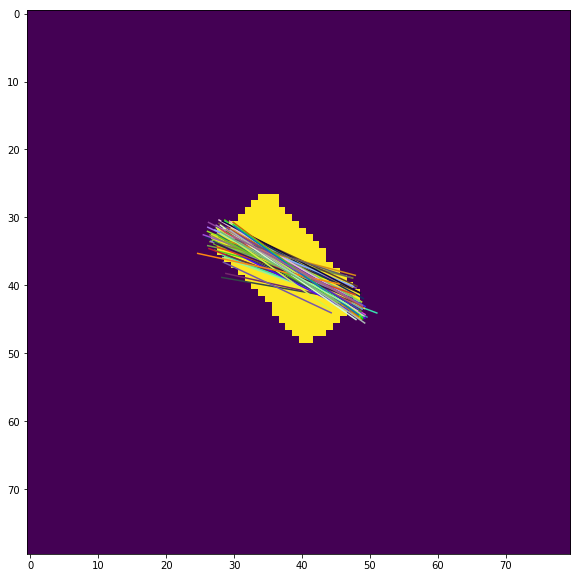

In [132]:
import matplotlib.pyplot as plt
import random

for vec, img, g in zip(vectors_batch, imgs_down, gt_class):
    # print(img.shape)
    
    plt.figure(figsize=(10,10))
    print('image')
    plt.imshow(img[0,:,:])
    
    # Add sorting code

    vec_subset =  random.sample(vec, 80)
    
    for v in vec_subset: # Can also randomly sample vectors here
        print(v)
        a, v1, v2 = v
        
        #plt.plot(*v[0], *v[1], c=np.random.rand(3,))
        plt.plot([v1[0],v2[0] ],[v1[1],v2[1]],c=np.random.rand(3,))
    
    plt.show()

In [87]:
!git commit -am "add minimal version of code"

[pawan_files 16998eb] add minimal version of code
 1 file changed, 0 insertions(+), 0 deletions(-)


In [89]:
%env http_proxy http://proxy.ncbs.res.in:3128
%env https_proxy http://proxy.ncbs.res.in:3128

env: http_proxy=http://proxy.ncbs.res.in:3128
env: https_proxy=http://proxy.ncbs.res.in:3128


In [90]:
!git push

Git 2.0 from 'matching' to 'simple'. To squelch this message
and maintain the traditional behavior, use:

  git config --global push.default matching

To squelch this message and adopt the new behavior now, use:

  git config --global push.default simple

When push.default is set to 'matching', git will push local branches
to the remote branches that already exist with the same name.

Since Git 2.0, Git defaults to the more conservative 'simple'
behavior, which only pushes the current branch to the corresponding
remote branch that 'git pull' uses to update the current branch.

See 'git help config' and search for 'push.default' for further information.
(the 'simple' mode was introduced in Git 1.7.11. Use the similar mode
'current' instead of 'simple' if you sometimes use older versions of Git)

Counting objects: 19, done.
Delta compression using up to 20 threads.
Compressing objects: 100% (19/19), done.
Writing objects: 100% (19/19), 3.61 KiB | 0 bytes/s, done.
Total 19 (delta 14), reu

In [118]:
!git status

On branch pawan_files
Your branch is up-to-date with 'origin/pawan_files'.
Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.ipynb_checkpoints/
	RotationEllipseDetection.ipynb
	TrainingRotation-Pfunctions-multi-square.ipynb

nothing added to commit but untracked files present (use "git add" to track)


In [119]:
!git add RotationEllipseDetection.ipynb

In [120]:
!git commit -am "add ellipse clustering file"

[pawan_files 9dafcc6] add ellipse clustering file
 1 file changed, 667 insertions(+)
 create mode 100644 RotationEllipseDetection.ipynb


In [121]:
!git push

Git 2.0 from 'matching' to 'simple'. To squelch this message
and maintain the traditional behavior, use:

  git config --global push.default matching

To squelch this message and adopt the new behavior now, use:

  git config --global push.default simple

When push.default is set to 'matching', git will push local branches
to the remote branches that already exist with the same name.

Since Git 2.0, Git defaults to the more conservative 'simple'
behavior, which only pushes the current branch to the corresponding
remote branch that 'git pull' uses to update the current branch.

See 'git help config' and search for 'push.default' for further information.
(the 'simple' mode was introduced in Git 1.7.11. Use the similar mode
'current' instead of 'simple' if you sometimes use older versions of Git)

Counting objects: 3, done.
Delta compression using up to 20 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 237.05 KiB | 0 bytes/s, done.
Total 3 (delta 1), reused 0

In [122]:
!git status

On branch pawan_files
Your branch is up-to-date with 'origin/pawan_files'.
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   RotationEllipseDetection.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.ipynb_checkpoints/
	TrainingRotation-Pfunctions-multi-square.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git commit -am "sparse density visualization working fine. add "